In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
from scipy.io import loadmat

from tsfresh import extract_relevant_features

import os

In [32]:
files = [f for f in os.listdir('waveforms') if 'clean' in f and 'diast' not in f and 'trended' not in f]

file = files[0]

mat = loadmat(f'waveforms/{file}')

waveforms = mat['savecleanforms'][0][0][2][0]

display(mat)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Wed Dec  6 16:04:33 2017',
 '__version__': '1.0',
 '__globals__': [],
 'savecleanforms': array([[(array([[  65,  230,  421,  620,  830, 1024, 1217, 1415]], dtype=uint16), array([[ 270,  461,  660,  870, 1064, 1257, 1455, 1644]], dtype=uint16), array([[array([[-11.17374808, -11.07351842, -10.91328877, -10.67305911,
                         -10.37282945, -10.0925998 ,  -9.81237014,  -9.51214048,
                          -9.21191083,  -8.93168117,  -8.67145151,  -8.37122186,
                          -8.0709922 ,  -7.79076254,  -7.55053289,  -7.31030323,
                          -7.09007357,  -6.92984392,  -6.76961426,  -6.5493846 ,
                          -6.38915495,  -6.28892529,  -6.22869563,  -6.16846598,
                          -6.10823632,  -6.06800666,  -6.04777701,  -6.04754735,
                          -6.06731769,  -6.12708804,  -6.20685838,  -6.26662873,
                          -6.30639907,  -6.366169

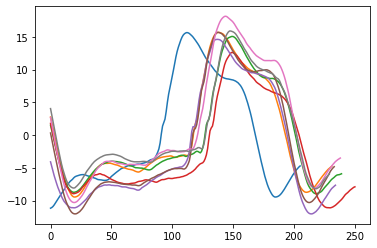

In [31]:
for waveform in waveforms:
    waveform = waveform[0]
    plt.plot(waveform)

In [11]:
# data = mat['wave'][0][0][13][3]

files = [f for f in os.listdir('waveforms') if 'clean' in f and 'diast' not in f and 'trended' not in f]

files_ = [f for f in files if 'HG8707' in f or 'HJ3311' in f]

# file = files[0]

# mat = loadmat(f'waveforms/{file}')

# for i in range(0, len(mat['wave'][0][0])):
#     display(mat['wave'][0][0][i])

for file in files_:
    mat = loadmat(f'waveforms/{file}')
    display(mat['wave'][0][0])
    continue
    channels = [
        file,
        mat['wave'][0][0][10][0],
        mat['wave'][0][0][10][0],
        mat['wave'][0][0][11][0],
        mat['wave'][0][0][12][0],
    ]
    display(channels)

(array(['THERRIAULT, SANDRA\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0031575517\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00WAXMAN, AARON  M.D.\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00RIGHT HEART CATH\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0010-24-2017\x00\x0012:26:27\x00\x00\x00\x00\x00\x00\x00\x00\x06\x00\x10\x00ÿÿ\x07\x00\x10\x00ÿÿ'],
      dtype='<U160'), array(['THERRIAULT, SANDRA'], dtype='<U30'), array(['31575517'], dtype='<U10'), array(['\x00WAXMAN, AARON  M.D.'], dtype='<U31'), array(['\x00RIGHT HEART CATH'], dtype='<U31'), array(['\x0010-24-2017'], dtype='<U11'), array(['12:26:27'], dtype='<U8'), array(['C:\\Users\\Nick\\Dropbox\\indy_research\\waveformextractor\\REST\\HG8707\\WAVES\\HG8707_WAV_000.PWS'],
      dtype='<U90'), array([[370.32, 421.22, 375.4 , ...,  34.32,   0.  ,  46.68]]), array(['AO'], dtype='<U3'), array(['LV'], dtype='<U3'), array([''], dtype='<U3'), array([''], dtype='<U3'), array([[-0.46, -0.

(array(['COLLETTE, DEBRA\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0023221476\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x009-28-2012\x00\x00\x0008:49:51\x00\x00\x00\x00\x00\x00\x00\x00\x06'],
      dtype='<U160'), array(['COLLETTE, DEBRA'], dtype='<U30'), array(['23221476'], dtype='<U10'), array([''], dtype='<U31'), array([''], dtype='<U31'), array(['\x009-28-2012'], dtype='<U11'), array(['08:49:51'], dtype='<U8'), array(['C:\\Users\\Nick\\Dropbox\\indy_research\\waveformextractor\\REST\\HJ3311\\WAVES\\HJ3311_WAV_000.PWS'],
      dtype='<U90'), array([[405.82, 390.64, 431.46, ...,  33.14,   0.  ,  55.38]]), array(['AO'], dtype='<U3'), array(['LV'], dtype='<U3'), array([''], dtype='<U3'), array(

In [41]:
files = [f for f in os.listdir('waveforms') if '_000.mat' in f]

# Load labels into Data Series
y_dict = {}
for file in files:
    y_dict[file_name] = int(data[0] % 2)  # Dummy Label

# Load time series into DataFrame
df_list = []
for file in files:
    # Load sample ECG data from the downloaded MATLAB file
    mat = loadmat(f'waveforms/{file}')
    data = mat['wave'][0][0][13][3]
    
    file_name = file.split('_')[0]
    
    for i, d in enumerate(data):
        df_dict = {
            'id':    file.split('_')[0],
            'time':    i,
            'value':   data[i],
        }
        
        df_list.append(df_dict)
        
d = [file.split('_')[0] for file in files]
df = pd.DataFrame(df_list)
y_df = pd.Series(y_dict, index=d)
display(df)
display(y_df)

,id,time,value
0,EL1001,0,20.52
1,EL1001,1,20.16
2,EL1001,2,19.80
3,EL1001,3,19.42
4,EL1001,4,19.10
...,...,...,...
202995,HK502,1745,7.34
202996,HK502,1746,7.44
202997,HK502,1747,7.50
202998,HK502,1748,7.56


EL1001    0
EL1026    1
EL1029    1
EL102     0
EL1038    0
         ..
EL94      0
EL978     0
HG8707    0
HJ3311    1
HK502     0
Length: 116, dtype: int64

In [42]:
features_filtered_direct = extract_relevant_features(df, y_df,
                                                     column_id='id', column_sort='time',
                                                     column_value='value')

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 29/29 [01:10<00:00,  2.42s/it]


In [43]:
features_filtered_direct

""
EL1001
EL102
EL1026
EL1029
EL103
...
EL948
EL978
HG8707
HJ3311


In [48]:
from tsfresh import extract_features
extracted_features = extract_features(df, column_id='id', column_sort='time',
                                      column_value=None)


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 29/29 [01:09<00:00,  2.40s/it]


In [49]:
extracted_features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,"value__matrix_profile__feature_""min""__threshold_0.98","value__matrix_profile__feature_""max""__threshold_0.98","value__matrix_profile__feature_""mean""__threshold_0.98","value__matrix_profile__feature_""median""__threshold_0.98","value__matrix_profile__feature_""25""__threshold_0.98","value__matrix_profile__feature_""75""__threshold_0.98"
EL1001,1.0,0.0,0.0,1.0,17583.32,2.860106e+05,0.263877,-0.006495,0.000469,6.48,...,1.638009,1.958918,2.260400,NaN,5.574511,8.467860,6.670557,6.612661,6.341505,6.998335
EL102,1.0,0.0,0.0,1.0,29793.02,6.250443e+05,0.370715,-0.009846,0.000074,13.10,...,1.559883,1.871229,2.184080,NaN,7.984148,11.441423,9.196200,8.938681,8.500162,9.454249
EL1026,1.0,0.0,0.0,1.0,7473.12,1.905120e+05,0.609720,-0.010978,0.000486,1.22,...,1.951421,2.416741,2.883854,NaN,4.550802,23.192228,11.071811,8.714063,6.992837,15.557422
EL1029,1.0,0.0,0.0,1.0,29573.70,1.060952e+06,0.526152,0.009605,0.000395,5.87,...,1.934853,2.363008,2.771876,NaN,5.515255,44.403564,10.963022,9.829781,5.722527,10.207241
EL103,1.0,0.0,0.0,1.0,24137.88,7.409315e+05,0.449548,0.008542,0.000441,4.36,...,1.775199,2.144695,2.487014,NaN,3.350878,41.981772,11.076234,7.324884,6.996517,7.973861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EL948,1.0,0.0,1.0,1.0,18508.18,3.472364e+05,0.372236,-0.007364,-0.000006,6.57,...,1.582997,1.901125,2.214337,NaN,3.869448,7.829773,5.357624,5.050719,4.335787,6.106811
EL978,1.0,0.0,0.0,1.0,42451.60,2.189510e+06,0.903259,-0.027284,0.000475,10.25,...,1.672320,2.021096,2.354805,NaN,4.248040,7.901722,5.945856,5.943356,4.993929,7.010825
HG8707,1.0,0.0,0.0,1.0,635.80,3.475205e+04,0.803122,-0.001521,0.000051,-0.24,...,2.997798,3.860279,4.665168,NaN,3.376056,15.176301,7.358701,4.905353,4.443624,12.774463
HJ3311,1.0,0.0,0.0,1.0,-3377.56,4.290975e+04,0.524951,0.001795,-0.000080,-2.48,...,2.093372,2.620696,3.124031,NaN,3.919860,11.370129,6.485445,6.683386,4.683756,7.729727


In [50]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

impute(extracted_features)
features_filtered = select_features(extracted_features, y_df)


C:\Users\andre\miniconda3\envs\epahClassification\lib\site-packages\tsfresh\utilities\dataframe_functions.py:171: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(


In [51]:
features_filtered

""
EL1001
EL102
EL1026
EL1029
EL103
...
EL948
EL978
HG8707
HJ3311


In [76]:
list(extracted_features.columns)

['value__variance_larger_than_standard_deviation',
 'value__has_duplicate_max',
 'value__has_duplicate_min',
 'value__has_duplicate',
 'value__sum_values',
 'value__abs_energy',
 'value__mean_abs_change',
 'value__mean_change',
 'value__mean_second_derivative_central',
 'value__median',
 'value__mean',
 'value__length',
 'value__standard_deviation',
 'value__variation_coefficient',
 'value__variance',
 'value__skewness',
 'value__kurtosis',
 'value__root_mean_square',
 'value__absolute_sum_of_changes',
 'value__longest_strike_below_mean',
 'value__longest_strike_above_mean',
 'value__count_above_mean',
 'value__count_below_mean',
 'value__last_location_of_maximum',
 'value__first_location_of_maximum',
 'value__last_location_of_minimum',
 'value__first_location_of_minimum',
 'value__percentage_of_reoccurring_values_to_all_values',
 'value__percentage_of_reoccurring_datapoints_to_all_datapoints',
 'value__sum_of_reoccurring_values',
 'value__sum_of_reoccurring_data_points',
 'value__rati